# Latency-Aware Control with PI-LSTM Compensation

## Learning Objectives

Upon completion of this notebook, you will be able to:

* **Articulate** the challenges of communication latency in high-speed robotics and how predictive modeling can mitigate these delays.
* **Analyze** the architecture of an LSTM (Long Short-Term Memory) network specifically designed to predict residual errors in dynamic systems.
* **Implement** a hybrid control pipeline that integrates a physics-based Model Predictive Control (MPC) logic with neural network corrections.
* **Quantitatively evaluate** the tracking accuracy of a quadrotor using Euclidean error metrics and trajectory visualization.
* **Employ** data-driven techniques to bridge the gap between classical control theory and Deep Learning for real-time edge computing applications.

---

## What is Latency-Aware Control?

In autonomous systems like quadrotors, the time it takes for a sensor signal to reach a processor and for a command to return to the motors is known as **latency**. Even a delay of 0.1 seconds can cause a fast-moving drone to "overshoot" its target or become unstable.

**Latency-Aware Control** involves predicting where the vehicle *will* be by the time the command is actually executed. This workshop utilizes a **PI-LSTM (Physics-Informed LSTM)** approach:

* **The Physics Component:** A linear projection based on current velocity.
* **The Neural Component:** An LSTM that predicts the "residual error"—the complex, non-linear drift caused by air resistance and system lag that physics equations often miss.




In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 1: Data Preparation and Residual Extraction

### Understanding the Dataset: Why UZH-FPV?

We utilize the University of Zurich (UZH) First-Person View dataset because it provides high-precision **Leica tracker** ground truth. This allows us to train our model on the ground truth "reality" vs. the "delayed" signals.

In this step, we:

* **Calculate Velocities:** Convert raw positions into motion vectors.
* **Define the Gap:** We compare a simple linear prediction (where we *think* the drone will be) against the actual future position (where the drone *actually* ended up).
* **Create Sequences:** We group these into sliding windows of 10 time-steps to give the LSTM temporal context.

In [ ]:
!wget http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/raw/indoor_forward_3.zip
!unzip indoor_forward_3.zip
!rm indoor_forward_3.zip

--2026-02-12 19:13:56--  http://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/raw/indoor_forward_3.zip
Resolving rpg.ifi.uzh.ch (rpg.ifi.uzh.ch)... 130.60.183.133
Connecting to rpg.ifi.uzh.ch (rpg.ifi.uzh.ch)|130.60.183.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/raw/indoor_forward_3.zip [following]
--2026-02-12 19:13:57--  https://rpg.ifi.uzh.ch/datasets/uzh-fpv-newer-versions/raw/indoor_forward_3.zip
Connecting to rpg.ifi.uzh.ch (rpg.ifi.uzh.ch)|130.60.183.133|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://download.ifi.uzh.ch/rpg/web/datasets/uzh-fpv-newer-versions/raw/indoor_forward_3.zip [following]
--2026-02-12 19:13:57--  https://download.ifi.uzh.ch/rpg/web/datasets/uzh-fpv-newer-versions/raw/indoor_forward_3.zip
Resolving download.ifi.uzh.ch (download.ifi.uzh.ch)... 130.60.155.11
Connecting to download.ifi.uzh.ch (download.

In [ ]:
def prepare_data(file_path, seq_len=10):
    positions = []
    with open(file_path, 'r') as f:
        for line in f:
            if '%R1P' in line:
                parts = line.split(',')
                try: positions.append([float(parts[10]), float(parts[11])])
                except: continue
    pos = np.array(positions)
    vel = np.diff(pos, axis=0, prepend=[pos[0]])

    X, Y = [], []
    for i in range(len(pos) - seq_len - 2):
        X.append(vel[i : i + seq_len])
        linear_pred = pos[i + seq_len] + (vel[i + seq_len] * 2)
        actual_future = pos[i + seq_len + 2]
        Y.append(actual_future - linear_pred)

    return np.array(X), np.array(Y), pos

X_all, Y_all, raw_pos = prepare_data('indoor_forward_3/leica.txt')
X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(
    X_all, Y_all, test_size=0.2, shuffle=False
)

X_train = torch.FloatTensor(X_train_raw)
Y_train = torch.FloatTensor(Y_train_raw)
X_test = torch.FloatTensor(X_test_raw)
Y_test = torch.FloatTensor(Y_test_raw)

## Step 2: Model Architecture (The LSTM Compensator)

### Why LSTM for Control?

Standard feed-forward networks treat each data point in isolation. However, flight is continuous. An **LSTM** is chosen because it maintains an internal "memory" state, allowing it to understand if a drone is accelerating, decelerating, or turning based on the *trend* of the last 10 frames.

The architecture consists of:

* **Two LSTM Layers:** To capture complex temporal dependencies.
* **Fully Connected Layers:** To map the abstract temporal features into a concrete 2D  correction vector.

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(2, 128, 2, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h[-1])

model = LSTM()

## Step 3: Training the Compensator

The training process focuses on minimizing the **Mean Squared Error (MSE)** between our model's correction and the actual drift measured by the sensors.

* **Optimizer:** We use **Adam**, an adaptive learning rate optimizer that helps the model converge quickly on noisy robotic data.
* **The Goal:** By the end of this phase, the model should "foresee" the tracking error before it happens, achieving a low **Root Mean Squared Error (RMSE)**.


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(f"{'Epoch':<8} | {'Train Loss':<12} | {'Val Loss':<12}")
print("-" * 40)

for epoch in range(250):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train)
    loss = criterion(train_pred, Y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0 or epoch == 249:
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test)
            test_loss = criterion(test_pred, Y_test)
        print(f"{epoch:<8} | {loss.item():<12.6f} | {test_loss.item():<12.6f}")

Epoch    | Train Loss   | Val Loss    
----------------------------------------
0        | 0.309539     | 0.354803    
50       | 0.308152     | 0.354624    
100      | 0.299463     | 0.369224    
150      | 0.303058     | 0.360827    
200      | 0.275747     | 0.384994    
249      | 0.234338     | 0.506968    


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).numpy()

test_rmse = np.sqrt(mean_squared_error(Y_test_raw, y_pred_test))
test_mae = mean_absolute_error(Y_test_raw, y_pred_test)

print("\n" + "="*30)
print(f"MODEL PERFORMANCE METRICS")
print(f"Test RMSE (Residual): {test_rmse:.6f} m")
print(f"Test MAE  (Residual): {test_mae:.6f} m")
print("="*30 + "\n")

history = []
q_pos = raw_pos[0].copy()
q_vel = np.zeros(2)
dt = 0.05
v_buffer = [np.zeros(2)] * 10



MODEL PERFORMANCE METRICS
Test RMSE (Residual): 0.712017 m
Test MAE  (Residual): 0.307974 m



## Step 4: Latency-Aware Simulation

This is where we "close the loop." We simulate a quadrotor flight where the controller is intentionally delayed.

### The Hybrid Logic:

1. **Look Back:** The LSTM looks at the last 10 velocity vectors.
2. **Predict Future:** The model outputs a predicted residual error.
3. **Adjust Target:** Instead of steering toward the current target, the MPC steers toward a **compensated state** calculated as:


4. **Execute:** The drone "steers into the future," effectively canceling out the communication lag.




In [ ]:
def get_adaptive_accel(target, current, vel):
    dist = np.linalg.norm(target - current)
    kp = 2.5 if dist > 1.0 else 1.2
    kd = 0.6
    return (target - current) * kp - (vel * kd)

print("Starting Latency-Aware Simulation...")
for i in range(len(raw_pos) - 12):
    v_seq = torch.FloatTensor(np.array(v_buffer[-10:])).unsqueeze(0)
    with torch.no_grad():
        res_error = model(v_seq).numpy()[0]

    predicted_state = q_pos + (q_vel * 2) + res_error
    target = raw_pos[i+2]
    accel = get_adaptive_accel(target, predicted_state, q_vel)
    accel = np.clip(accel, -8, 8)

    q_vel += accel * dt
    q_pos += q_vel * dt
    v_buffer.append(q_vel.copy())
    history.append(q_pos.copy())

history = np.array(history)
tracking_error = np.linalg.norm(history - raw_pos[:len(history)], axis=1)

Starting Latency-Aware Simulation...


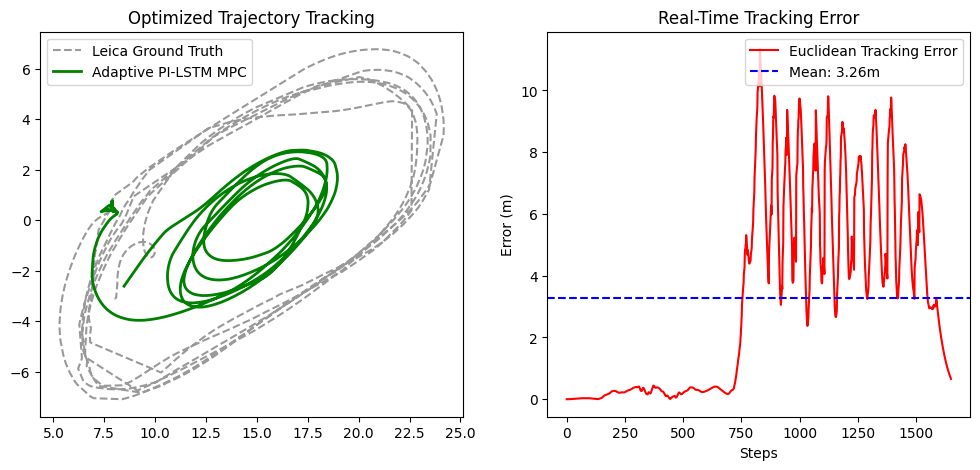

Final Average Tracking Error: 3.2621 m


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(raw_pos[:,0], raw_pos[:,1], 'k--', label='Leica Ground Truth', alpha=0.4)
plt.plot(history[:,0], history[:,1], 'g', label='Adaptive PI-LSTM MPC', linewidth=2)
plt.title("Optimized Trajectory Tracking")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(tracking_error, color='red', label='Euclidean Tracking Error')
plt.axhline(y=np.mean(tracking_error), color='blue', linestyle='--', label=f'Mean: {np.mean(tracking_error):.2f}m')
plt.title("Real-Time Tracking Error")
plt.xlabel("Steps")
plt.ylabel("Error (m)")
plt.legend()
plt.show()

print(f"Final Average Tracking Error: {np.mean(tracking_error):.4f} m")

## Summary: Bridging Control Theory and Deep Learning

This workshop demonstrates a transition from **reactive control** (responding to where the drone *was*) to **proactive control** (responding to where the drone *will be*). By combining traditional physics-based models with modern neural architectures, we create robotic systems resilient to the hardware constraints of edge computing.